<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Test8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Colab Notebooks/data.zip" .
!unzip data.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  data.zip
replace data/test/n_00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( rescale=1./255, # 255で割ることで正規化
                              featurewise_center = False,
                              samplewise_center = False,
                              featurewise_std_normalization = False,
                              samplewise_std_normalization = False,
                              zca_whitening = False,
                              rotation_range = 10,
                              #width_shift_range = 0.3,
                              #height_shift_range = 0.3,
                              horizontal_flip = True,
                              vertical_flip = False,
                              validation_split = 0.2
                            )

In [8]:
train_dir = './data/train'
BATCH_SIZE = 32

train_generator = datagen.flow_from_directory(
            train_dir,
            target_size=(256,256),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            subset = "training"
  )

val_generator = datagen.flow_from_directory(
            train_dir,
            target_size=(256,256),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            subset = "validation"
)

Found 3393 images belonging to 8 classes.
Found 845 images belonging to 8 classes.


In [9]:
from tensorflow.keras.applications import densenet

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_DEPTH = 3

base_model = densenet.DenseNet121(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )

base_model.trainable = False
"""
for layer in base_model.layers[-60:]:
    layer.trainable = True
"""

29084464/29084464 [==============================] - 0s 0us/step


'\nfor layer in base_model.layers[-60:]:\n    layer.trainable = True\n'

In [10]:
from tensorflow.keras import datasets, layers, models, applications, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten

CATEGORY_NUM = 8

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(CATEGORY_NUM, activation='softmax')
])

adam_low_rate = optimizers.Adam(learning_rate=0.001)

In [11]:
# モデルの概要
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 1024)              67109888  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               2

In [12]:
# モデルを構築
model.compile(optimizer=adam_low_rate,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
from tensorflow import keras

# Early stoppingを適用してフィッティング
log = model.fit(
                  train_generator,
                  validation_data = val_generator,
                  steps_per_epoch = train_generator.samples // BATCH_SIZE,
                  validation_steps = val_generator.samples // BATCH_SIZE,
                  verbose=True,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                  epochs = 10,
                  workers = 1
)

Epoch 1/10
106/106 [==============================] - 92s 729ms/step - loss: 4.5951 - accuracy: 0.4844 - val_loss: 0.8977 - val_accuracy: 0.6538
Epoch 2/10
106/106 [==============================] - 73s 692ms/step - loss: 0.9313 - accuracy: 0.6703 - val_loss: 0.8920 - val_accuracy: 0.6935
Epoch 3/10
106/106 [==============================] - 67s 632ms/step - loss: 0.7904 - accuracy: 0.7245 - val_loss: 0.7567 - val_accuracy: 0.7344
Epoch 4/10
106/106 [==============================] - 74s 699ms/step - loss: 0.6773 - accuracy: 0.7587 - val_loss: 0.7693 - val_accuracy: 0.7284
Epoch 5/10
106/106 [==============================] - 75s 705ms/step - loss: 0.6259 - accuracy: 0.7771 - val_loss: 0.7079 - val_accuracy: 0.7416
Epoch 6/10
106/106 [==============================] - 73s 691ms/step - loss: 0.6388 - accuracy: 0.7807 - val_loss: 0.7403 - val_accuracy: 0.7296
Epoch 7/10
106/106 [==============================] - 75s 704ms/step - loss: 0.4816 - accuracy: 0.8274 - val_loss: 0.7921 - val_ac

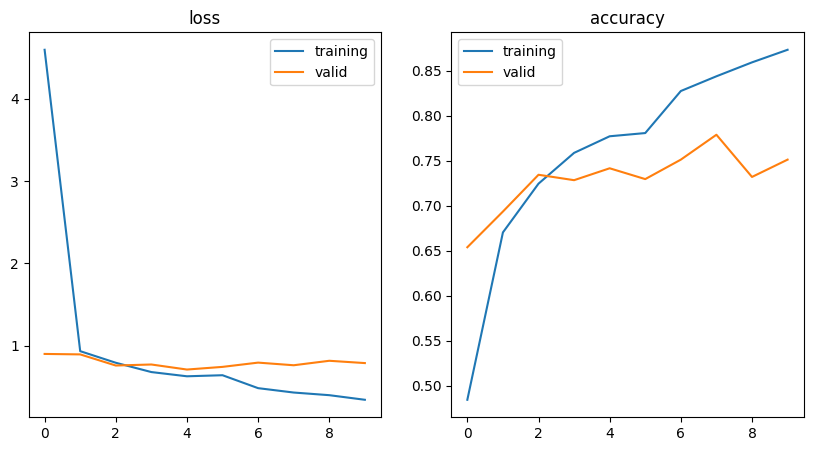

In [14]:
import matplotlib.pyplot as plt
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意

for i in range(len(metrics)):

    metric = metrics[i]

    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
    plt.title(metric)

    plt_train = log.history[metric]
    plt_valid  = log.history['val_' + metric]

    plt.plot(plt_train, label='training')
    plt.plot(plt_valid, label='valid')
    plt.legend()

plt.savefig("metrics.jpg")

In [17]:
# 評価する。
test_loss, test_acc = model.evaluate(val_generator)

print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2%}")
model.save('/content/drive/MyDrive/Colab Notebooks/cnn_dense121.h5')

27/27 [==============================] - 13s 491ms/step - loss: 0.7781 - accuracy: 0.7503
test loss: 0.78, test accuracy: 75.03%


In [31]:
test_dir = './data/test'

import os
import shutil
import glob

os.makedirs('./data/test/test', exist_ok=True)
for image_path in glob.glob(test_dir + '/*'):
    shutil.move(image_path, test_dir + '/dummy')

Error: Destination path './data/test/dummy/test' already exists

In [32]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(256,256), batch_size=64, class_mode=None, shuffle=False)

Found 587 images belonging to 3 classes.


In [37]:
import numpy as np
prediction = model.predict(test_generator)
results = np.argmax(prediction,axis=1)
print(results)
np.savetxt('/content/drive/MyDrive/Colab Notebooks/save_ored.txt', results)

10/10 [==============================] - 2s 215ms/step
[1 2 7 7 0 4 4 1 1 1 1 0 0 4 1 0 0 1 0 2 1 0 2 0 4 0 1 0 0 1 0 4 4 1 0 3 0
 0 4 0 1 1 0 4 2 1 1 0 2 3 4 0 4 0 0 1 1 7 0 0 4 4 2 4 1 4 0 1 0 1 1 4 2 0
 0 2 1 0 0 2 0 0 4 1 4 4 0 1 1 1 1 0 1 3 1 0 1 1 0 1 0 3 1 1 1 0 3 3 0 0 4
 0 0 4 0 1 4 3 4 1 4 7 1 3 0 4 1 2 3 4 7 1 1 1 4 0 3 4 1 4 3 2 1 0 2 2 1 3
 4 2 4 4 1 2 4 1 1 1 3 7 2 2 1 2 2 1 1 4 0 3 4 2 1 2 1 1 4 3 2 1 1 0 3 4 1
 4 0 0 4 6 1 0 0 2 1 1 2 2 4 1 4 0 4 1 0 4 0 2 1 0 2 3 4 0 2 4 7 2 0 0 1 1
 0 4 4 1 2 0 2 0 4 6 2 4 1 0 0 3 0 2 0 1 3 4 2 2 3 4 4 0 3 1 4 4 0 2 0 4 2
 4 1 2 3 0 3 4 1 2 1 4 3 3 1 0 0 3 0 0 1 1 1 0 7 0 0 1 1 1 4 3 0 4 1 1 1 0
 4 4 0 2 1 4 0 7 6 1 0 3 1 4 4 2 6 4 1 3 4 4 0 2 0 4 3 0 0 1 1 0 4 0 0 0 3
 1 1 0 0 0 0 0 4 2 1 0 2 1 4 0 0 1 0 2 7 1 0 4 4 1 0 4 4 2 1 4 0 0 1 1 2 0
 0 1 7 0 0 4 1 2 1 3 2 1 4 0 1 1 2 0 4 2 4 7 4 0 0 2 1 2 1 4 1 0 4 0 3 2 0
 1 2 1 1 2 1 0 1 1 0 3 1 0 0 3 0 2 4 6 0 1 0 4 3 4 1 4 4 4 1 4 4 3 1 3 1 2
 0 4 0 0 2 0 1 4 0 1 3 1 1 1 0 1 0 0 1 4 2 1 